<a href="https://colab.research.google.com/github/Ermi1223/amharic-hate-speech-api/blob/main/Amharic_Hate_Speech_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Amharic Hate Speech Detection using fine-tuned mBERT**

(multilingual Bidirectional Encoder Representations from Transformer)

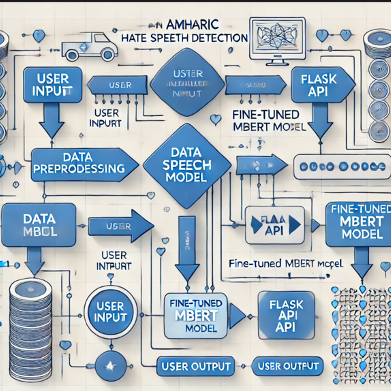

The diagram illustrates the architecture of the Amharic Hate Speech Detection System in a clear and structured flow. Here's a breakdown of the design:

**1. User Input**
Description: This is where the user provides a text input for analysis. The text could contain potential hate speech in Amharic.
Purpose: Acts as the entry point for the system.

**2. Data Preprocessing**
Description: Before the text can be analyzed, it is preprocessed to ensure it is clean and suitable for the model.
Removing irrelevant characters or symbols.
Tokenizing the text into manageable components.
Encoding the data using the tokenizer of the fine-tuned mBERT model.
Purpose: Prepares the text for accurate processing by the model.

**3. Fine-tuned mBERT Model**
Description: The preprocessed text is fed into the fine-tuned multilingual BERT (mBERT) model for classification. This model has been specifically trained to identify Amharic hate speech.
Outputs the prediction (e.g., "Hate Speech" or "Not Hate Speech").
Purpose: The core component responsible for understanding and classifying the input text.

**4. Flask API**

Description: The Flask API serves as the intermediary between the user and the machine learning model. It:
Accepts user requests (text input).
Sends the text to the preprocessing and prediction pipeline.
Returns the model’s output to the user.
Purpose: Provides a user-friendly interface for accessing the system via web or application-based platforms.

**5. User Output**

Description: The final step delivers the model's prediction back to the user. For example:
"The text contains Hate Speech."
"The text does not contain Hate Speech."
Purpose: Ensures the system provides actionable insights based on the input text.

To implement this project follow the following step

**Step 1:** Install the necessary packages
We need two packages:


*   Transformers package made available by Huggingface
*   Dataset package made availale by Huggingface







In [ ]:
pip install scikit-learn datasets transformers

**Step 2:** Import the necessay libraries from the installed packages

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
num_labels = 2

# Load the pre-trained model and tokenizer
model_name = "amengemeda/amharic-hate-speech-detection-mBERT"
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

**Step 3:** Import the dataset to be used for Training the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 4:** Preprocess the Dataset
When the dataset was retrived, the labels and the content were in different files.

**First:** merging the files into one panda's dataframe.

**Second:** Lable encoding is the process of converting the labels(classes) into numeric format to make it easier for the machine to understand it.

**Third:** dividing the dataset into training, validation and testing categories. The division ratio is 7:1:2 respectively.
Last step is to remove an unncessary columns from the main dataset and merging the all the categories into one main dataset

1. **Loads and inspects the data**: It reads the train and test datasets and verifies column names before processing.

2. **Splits the combined column**: It separates the `Content,Label` column into two distinct columns, `Content` and `Label`.

3. **Handles missing values**: It removes rows with `NaN` values in either `Content` or `Label`.

4. **Cleans the labels**: Strips whitespace from `Label` values to ensure consistency.

5. **Maps labels to integers**: Creates a mapping from non-numeric labels to continuous integers, ensuring compatibility with machine learning models.

6. **Applies the mapping and verifies**: Updates the labels in the dataset and verifies the changes.

7. **Determines the number of labels**: Computes `num_labels` dynamically based on unique labels in the training data.

8. **Updates the model**: Configures the model to expect the correct number of labels.

In [ ]:
import pandas as pd

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/AMHSDataTrain.txt', delimiter=',')
test_data = pd.read_csv('/content/drive/MyDrive/AMHSDataTest.txt', delimiter=',')

# Check the columns before dropping NaN values to ensure correct names
print("Train data columns before split:", train_data.columns)
print("Test data columns before split:", test_data.columns)

# Split 'Content,Label' into 'Content' and 'Label' columns
train_data[['Content', 'Label']] = train_data['Content,Label'].str.split(',', expand=True)
test_data[['Content', 'Label']] = test_data['Content,Label'].str.split(',', expand=True)

# Drop the old combined column
train_data = train_data.drop(columns=['Content,Label'])
test_data = test_data.drop(columns=['Content,Label'])

# Check the columns after splitting
print("Train data columns after split:", train_data.columns)
print("Test data columns after split:", test_data.columns)

# Remove rows with missing values in both 'Content' and 'Label' columns
train_data = train_data.dropna(subset=['Content', 'Label'])
test_data = test_data.dropna(subset=['Content', 'Label'])

# Strip leading and trailing whitespace from labels to ensure consistent label names
train_data['Label'] = train_data['Label'].str.strip()
test_data['Label'] = test_data['Label'].str.strip()

# Map non-numeric labels to continuous integers
unique_labels = sorted(train_data['Label'].unique())  # Ensure no NaN values are present
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}  # Create mapping
print("Label Mapping:", label_mapping)

# Apply the mapping to the Label column
train_data['Label'] = train_data['Label'].map(label_mapping)
test_data['Label'] = test_data['Label'].map(label_mapping)

# Verify the changes
print("Train dataset after label mapping:")
print(train_data.head())
print("Test dataset after label mapping:")
print(test_data.head())

# Define num_labels
num_labels = len(label_mapping)  # Set num_labels based on the actual number of unique labels in your dataset
print(f"Number of unique labels (num_labels): {num_labels}")

# Ensure the model is expecting the correct number of labels
model.num_labels = num_labels  # Update the model's num_labels to match the dataset's label count


Train data columns before split: Index(['Content,Label'], dtype='object')
Test data columns before split: Index(['Content,Label'], dtype='object')
Train data columns after split: Index(['Content', 'Label'], dtype='object')
Test data columns after split: Index(['Content', 'Label'], dtype='object')
Label Mapping: {'መልካም': 0, 'ጥላቻ': 1}
Train dataset after label mapping:
                                             Content  Label
0  ሌቦች የአብይን ፎቶ ከጀርባህ ለጥፈህ ትለፈልፋለህ አብይ ላይ ያለንም እም...      1
1                  ህዝቤ አንድ ቀን ትግሬን ይበቀላል ጊዜ ዳኛው ቶሎ ና      1
2                                   ህዝብን የጨርስህ ጅብ ነህ      1
3                   ህገ መንግስታችን ይከበር ምድረ ጅቦች ሰው በላ ሁላ      1
4                                            ሆዳም ባንዳ      1
Test dataset after label mapping:
                                             Content  Label
0  ዘረኛ ሰው ነው ስለሌላ ዘር ቀን ከለሊት ሲለፈልፍ የሚውለው  ዘረኛ መሆን...      1
1  ዘፈኑ ጥሩ ነው አንድ ሆዳም አማራ ግን የትግራይን የሽንት ጨርቅ በረጅም ...      1
2  ዛሬ ቅማላም ትግሬዎች በህዝባችን የተተፉና በገጀራ ዋጋቸውን የሚያገኙበት ...    

This line of code is used to display the number of rows and columns in the training (`train_data`) and testing (`test_data`) datasets after preprocessing. This information is crucial for ensuring the preprocessing steps were executed correctly and for confirming that the data is in the expected format.

In [ ]:
print("Train dataset shape (rows, columns):", train_data.shape)
print("Test dataset shape (rows, columns):", test_data.shape)

Train dataset shape (rows, columns): (1594, 2)
Test dataset shape (rows, columns): (396, 2)


1. **Inspect Columns**:
   The column names in the training and testing datasets are printed to confirm the structure is as expected after preprocessing.

2. **Check Unique Labels**:
   The unique labels in both datasets are displayed to identify inconsistencies or unexpected values.

3. **Encode Labels**:
   Labels are converted into numeric format using `LabelEncoder`, ensuring consistent mapping across training and testing datasets.

4. **Verify Encoded Labels**:
   After encoding, the unique numeric labels are verified to ensure correctness. For binary classification, labels should typically be `[0, 1]`.

5. **Set `num_labels`**:
   The number of unique labels is determined and stored in `num_labels`, ensuring the model's output layer matches the dataset's classification requirements.

6. **Initialize Model**:
   A pre-trained model is configured for sequence classification with the correct number of output labels.

**Step 5: Tokenizing Dataset**
A Tokenizer is used to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data.

In this case, the tokenizer used is an AutoTokenizer from the fine-tuned mBERT model made available by Hugging face here

**In this phase, we have the following tasks:**

Load the tokenizer
Create a tokenizer function that takes the dataset in batches and tokenize them using the tokenizer loaded from the model
Call the tokenizer function on the whole dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

print(train_data.columns)
print(test_data.columns)

# Check unique labels in train and test datasets
print("Unique train labels:", train_data['Label'].unique())
print("Unique test labels:", test_data['Label'].unique())
# Ensure label mapping is consistent
label_encoder = LabelEncoder()
train_data['Label'] = label_encoder.fit_transform(train_data['Label'])
test_data['Label'] = label_encoder.transform(test_data['Label'])

# Verify unique labels
print("Encoded Train Labels:", train_data['Label'].unique())  # Should be [0, 1] for binary classification
print("Encoded Test Labels:", test_data['Label'].unique())

# Update num_labels
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)



Index(['Content', 'Label'], dtype='object')
Index(['Content', 'Label'], dtype='object')
Unique train labels: [1 0]
Unique test labels: [1 0]
Encoded Train Labels: [1 0]
Encoded Test Labels: [1 0]


1. **Label Encoding**:
   - The `LabelEncoder` is used to transform the text labels in the `Label` column into numeric values.
   - The training data is encoded with `fit_transform`, which learns the mapping and applies it.
   - The test data is encoded with `transform`, ensuring the same mapping is applied.

2. **Verify Encoded Labels**:
   - After encoding, the unique numeric labels in both datasets are displayed for verification.
   - This ensures that the labels are consistent and correspond to their intended classes.

3. **Generate Label Mapping**:
   - The `label_mapping` dictionary is created to store the relationship between numeric labels and their original text counterparts.
   - This mapping helps interpret the numeric labels during analysis or evaluation.

4. **Print Label Mapping**:
   - The `label_mapping` is printed to confirm the mapping from numbers back to the original labels. For example, `{0: 'Positive', 1: 'Negative'}`.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_data['Label'] = label_encoder.fit_transform(train_data['Label'])
test_data['Label'] = label_encoder.transform(test_data['Label'])

print("Encoded Train Labels:", train_data['Label'].unique())
print("Encoded Test Labels:", test_data['Label'].unique())

# Verify label mapping
unique_labels = sorted(train_data['Label'].unique())
label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)


Encoded Train Labels: [1 0]
Encoded Test Labels: [1 0]
Label Mapping: {0: 0, 1: 1}


**Step 6: Prepare the tokenized Dataset**

In this phase, we do the following tasks:

Remove unnecessary columns such as the "posts" column from the tokenized dataset as we no longer need them
Change the format of the tokenized dataset into pytorch since we are using pytorch
Load the dataset using DataLoader with the proper batch size
Preview the features of the dataset to make sure everything is okay

- **Tokenization**: The `preprocess_data` function uses the tokenizer to convert text from the `Content` column into a format suitable for model input. It truncates texts to the specified maximum length and ensures padding where necessary.
  
- **Function Call**: The function is applied to both `train_data` and `test_data` to prepare them for model training and evaluation.


In [ ]:
#Update the tokenization function for error prevention:
def preprocess_data(data, tokenizer, max_length=512):
    encodings = tokenizer(
        data['Content'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length
    )
    return encodings

train_encodings = preprocess_data(train_data, tokenizer)
test_encodings = preprocess_data(test_data, tokenizer)


1. **Dataset Class**:
   - The `HateSpeechDataset` class inherits from `torch.utils.data.Dataset`, which allows you to load data in a way compatible with PyTorch’s data pipeline.
   - **`__init__`**: Takes tokenized data (`encodings`) and labels, storing them as attributes.
   - **`__getitem__`**: This function fetches a data item by index (`idx`), converting the input (`Content`) and the target (`Label`) into PyTorch tensors.
   - **`__len__`**: Returns the number of items (labels) in the dataset.

2. **Preparing Labels**:
   - The `train_labels` and `test_labels` are extracted from the `Label` columns of the training and testing datasets (`train_data` and `test_data`).
   - These labels are converted to lists to match the format expected by the `HateSpeechDataset`.

3. **Creating the Dataset Objects**:
   - The `train_dataset` and `test_dataset` are instantiated with the encoded tokenized data (`train_encodings`, `test_encodings`) and their corresponding labels (`train_labels`, `test_labels`).

In [ ]:
#Ensure the labels are numeric and within bounds. Update the dataset class:
import torch
from torch.utils.data import Dataset  # Import Dataset from torch.utils.data

class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Assuming train_data and test_data are pandas DataFrames and train_encodings/test_encodings are dictionaries
train_labels = train_data['Label'].tolist()
test_labels = test_data['Label'].tolist()

train_dataset = HateSpeechDataset(train_encodings, train_labels)
test_dataset = HateSpeechDataset(test_encodings, test_labels)


1. **Class Range Validation**: It ensures that the predicted and actual labels fall within the valid range of class indices. If the labels fall outside this range, an error is raised.
   
2. **Edge Case Handling**: The function accounts for situations where a class might not appear in either the predictions or true labels, using a method to avoid errors (like division by zero).

3. **Metric Calculation**: It computes the following metrics:
   - **Accuracy**: The proportion of correct predictions.
   - **Precision, Recall, and F1-Score**: These are calculated with a weighted average to handle class imbalance.

In [ ]:
#Modify the compute_metrics function to handle class range issues:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    predictions, labels = p
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)

    predictions = torch.argmax(predictions, dim=1)
    accuracy = accuracy_score(labels.cpu(), predictions.cpu())
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels.cpu(), predictions.cpu(), average='weighted'
    )
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


1. **Training Arguments (`TrainingArguments`)**:
   - `output_dir`: Directory where model checkpoints and results will be saved.
   - `num_train_epochs`: Number of times the model will iterate over the training data (set to 8 epochs).
   - `per_device_train_batch_size`: Batch size for training (8 in this case).
   - `per_device_eval_batch_size`: Batch size for evaluation (also set to 8).
   - `warmup_steps`: Number of warmup steps before learning rate scheduling starts (500 steps).
   - `weight_decay`: Regularization parameter to prevent overfitting (set to 0.01).
   - `logging_dir`: Directory for logging information.
   - `logging_steps`: Frequency of logging (every 10 steps).
   - `eval_strategy`: Defines when evaluation happens (here it's after every epoch).

2. **Trainer**:
   - `model`: The model to be trained.
   - `args`: The training arguments specified above.
   - `train_dataset`: The training dataset to be used.
   - `eval_dataset`: The evaluation (test) dataset.
   - `compute_metrics`: A function for calculating evaluation metrics like accuracy, precision, recall, and F1-score.

3. **Training**:
   - The `trainer.train()` method starts the training process with the specified settings and datasets.

**Step 7: Fine-tune the model**

This phase has the following steps:

Load the model
Specify the computing metric
Specify the Training/fine-tuning arguments
Load the Trainer class
Fine-tune the model

In [ ]:
from transformers import Trainer, TrainingArguments

# Adjust training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.422583,0.878788,0.880607,0.878788,0.878593
2,0.000000,1.608247,0.876263,0.879645,0.876263,0.875917
3,0.744100,0.699222,0.494949,0.244975,0.494949,0.327737
4,0.702000,0.743458,0.502525,0.254443,0.502525,0.337832


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,1.422583,0.878788,0.880607,0.878788,0.878593
2,0.000000,1.608247,0.876263,0.879645,0.876263,0.875917
3,0.744100,0.699222,0.494949,0.244975,0.494949,0.327737
4,0.702000,0.743458,0.502525,0.254443,0.502525,0.337832
5,0.360500,0.512939,0.782828,0.813028,0.782828,0.776999
6,0.682400,0.695195,0.494949,0.244975,0.494949,0.327737
7,0.509600,0.526231,0.843434,0.847129,0.843434,0.843114
8,0.118900,0.582210,0.851010,0.851068,0.851010,0.850990


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1600, training_loss=0.36264378020693644, metrics={'train_runtime': 1460.0526, 'train_samples_per_second': 8.734, 'train_steps_per_second': 1.096, 'total_flos': 3355192177950720.0, 'train_loss': 0.36264378020693644, 'epoch': 8.0})

**Step 8: Test the model**

In this stage the model is tested on the testing dataset. This dataset isn't seen by the model during the finetuning process.

In [ ]:
# Evaluate on a small subset
small_test_dataset = torch.utils.data.Subset(test_dataset, range(0, 100))
results = trainer.evaluate(eval_dataset=small_test_dataset)
print("Results on small test dataset:", results)

# Evaluate on the full test dataset
full_results = trainer.evaluate()
print("Results on full test dataset:", full_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results on small test dataset: {'eval_loss': 0.28414881229400635, 'eval_accuracy': 0.91, 'eval_precision': 1.0, 'eval_recall': 0.91, 'eval_f1': 0.9528795811518325, 'eval_runtime': 3.5016, 'eval_samples_per_second': 28.559, 'eval_steps_per_second': 3.713, 'epoch': 8.0}
Results on full test dataset: {'eval_loss': 0.5822102427482605, 'eval_accuracy': 0.851010101010101, 'eval_precision': 0.851067916460091, 'eval_recall': 0.851010101010101, 'eval_f1': 0.8509901428053845, 'eval_runtime': 13.9127, 'eval_samples_per_second': 28.463, 'eval_steps_per_second': 3.594, 'epoch': 8.0}


In [ ]:
full_results = trainer.evaluate()
print("Results on full test dataset:", full_results)


Results on full test dataset: {'eval_loss': 0.5822102427482605, 'eval_accuracy': 0.851010101010101, 'eval_precision': 0.851067916460091, 'eval_recall': 0.851010101010101, 'eval_f1': 0.8509901428053845, 'eval_runtime': 13.6202, 'eval_samples_per_second': 29.075, 'eval_steps_per_second': 3.671, 'epoch': 8.0}


**To manually calculate the classification metrics (accuracy, precision, recall, and F1-score) **
**without using `sklearn.metrics`,**

follow the definitions and compute them using basic tensor operations. Here’s a breakdown of how to manually compute these metrics step by step:

### 1. **Accuracy**
Accuracy is the ratio of correct predictions to total predictions.

\[
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
\]

### 2. **Precision**
Precision is the ratio of correctly predicted positive observations to the total predicted positives.

\[
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
\]

Where:
- \(TP_i\) = True Positives for class \(i\) (correctly predicted as class \(i\))
- \(FP_i\) = False Positives for class \(i\) (incorrectly predicted as class \(i\))

### 3. **Recall**
Recall is the ratio of correctly predicted positive observations to the all observations in the actual class.

\[
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
\]

Where:
- \(FN_i\) = False Negatives for class \(i\) (incorrectly predicted as other classes)

### 4. **F1-Score**
The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both.

\[
\text{F1}_i = 2 \times \frac{\text{Precision}_i \times \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
\]

In [ ]:
import torch

def compute_metrics(p):
    predictions, labels = p
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)

    predictions = torch.argmax(predictions, dim=1)

    # Convert to CPU tensors if on GPU
    labels = labels.cpu()
    predictions = predictions.cpu()

    # Handle class range issues
    all_classes = torch.unique(torch.cat([labels, predictions]))
    num_classes = len(all_classes)

    # Compute accuracy
    correct = (labels == predictions).sum().item()
    total = len(labels)
    accuracy = correct / total if total > 0 else 0

    # Initialize counts for precision, recall, F1-score
    true_positives = torch.zeros(num_classes)
    false_positives = torch.zeros(num_classes)
    false_negatives = torch.zeros(num_classes)

    # Count true positives, false positives, and false negatives
    for cls in all_classes:
        cls_mask = (labels == cls)
        pred_mask = (predictions == cls)

        true_positives[cls] = (cls_mask & pred_mask).sum().item()
        false_positives[cls] = (~cls_mask & pred_mask).sum().item()
        false_negatives[cls] = (cls_mask & ~pred_mask).sum().item()

    # Compute precision, recall, and F1-score
    precision = (true_positives / (true_positives + false_positives + 1e-10)).mean().item()
    recall = (true_positives / (true_positives + false_negatives + 1e-10)).mean().item()
    f1 = (2 * precision * recall / (precision + recall + 1e-10))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
from transformers import Trainer, TrainingArguments

# Adjust training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.452800,0.435077,0.833333,0.841435,0.832551,0.836970
2,0.275900,0.508703,0.840909,0.849784,0.840102,0.844915
3,0.116800,0.600248,0.876263,0.880002,0.875765,0.877878
4,0.103600,0.744240,0.876263,0.884907,0.875510,0.880184
5,0.003500,1.107542,0.815657,0.854544,0.813980,0.833769
6,0.000400,0.843209,0.878788,0.879501,0.878571,0.879036
7,0.001000,0.915907,0.878788,0.880332,0.878469,0.879400
8,0.065400,0.920167,0.886364,0.888209,0.886020,0.887113


TrainOutput(global_step=1600, training_loss=0.21177515241943184, metrics={'train_runtime': 1571.618, 'train_samples_per_second': 8.114, 'train_steps_per_second': 1.018, 'total_flos': 3355192177950720.0, 'train_loss': 0.21177515241943184, 'epoch': 8.0})

In [ ]:
# Evaluate on a small subset
small_test_dataset = torch.utils.data.Subset(test_dataset, range(0, 100))
results = trainer.evaluate(eval_dataset=small_test_dataset)
print("Results on small test dataset:", results)

# Evaluate on the full test dataset
full_results = trainer.evaluate()
print("Results on full test dataset:", full_results)

Results on small test dataset: {'eval_loss': 0.47890159487724304, 'eval_accuracy': 0.94, 'eval_precision': 0.5, 'eval_recall': 0.4699999988079071, 'eval_f1': 0.48453608179078916, 'eval_runtime': 3.5443, 'eval_samples_per_second': 28.214, 'eval_steps_per_second': 3.668, 'epoch': 8.0}
Results on full test dataset: {'eval_loss': 0.9201666116714478, 'eval_accuracy': 0.8863636363636364, 'eval_precision': 0.8882090449333191, 'eval_recall': 0.8860204219818115, 'eval_f1': 0.8871133835059565, 'eval_runtime': 14.2042, 'eval_samples_per_second': 27.879, 'eval_steps_per_second': 3.52, 'epoch': 8.0}


In [ ]:
full_results = trainer.evaluate()
print("Results on full test dataset:", full_results)


Results on full test dataset: {'eval_loss': 0.9201666116714478, 'eval_accuracy': 0.8863636363636364, 'eval_precision': 0.8882090449333191, 'eval_recall': 0.8860204219818115, 'eval_f1': 0.8871133835059565, 'eval_runtime': 13.6921, 'eval_samples_per_second': 28.922, 'eval_steps_per_second': 3.652, 'epoch': 8.0}


**Step 9: Push the model to Huggingface Hub**

One of the aims of this research/project is to contribute to the IT community in the sector of NLP tasks on low-resourced languages. Hence, the final model was pushed and made publicly available on Huggingface. You can find the model on huggingface. https://huggingface.co/ermi8/amharic-hate-speech-detection

In [ ]:
pip install transformers huggingface_hub

In [ ]:
#loggin to huggingface-cli
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) 
Token is valid (permission: fineGr

In [ ]:
# Save the model and tokenizer to Google Drive
model.save_pretrained("/content/drive/My Drive/Amharic hate speech detection")
tokenizer.save_pretrained("/content/drive/My Drive/Amharic hate speech detection")


('/content/drive/My Drive/Amharic hate speech detection/tokenizer_config.json',
 '/content/drive/My Drive/Amharic hate speech detection/special_tokens_map.json',
 '/content/drive/My Drive/Amharic hate speech detection/vocab.txt',
 '/content/drive/My Drive/Amharic hate speech detection/added_tokens.json')

Push the Model to Hugging Face

In [ ]:
from huggingface_hub import upload_folder, create_repo

# Repository name on Hugging Face
repo_name = "ermi8/amharic-hate-speech-detection"

# Create the repository (set `private=True` if needed)
create_repo(repo_name, private=False)

# Upload the folder from Google Drive
upload_folder(
    folder_path="/content/drive/My Drive/Amharic hate speech detection",
    repo_id=repo_name,
    commit_message="Initial upload of Amharic hate speech detection model"
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

vocab.txt:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ermi8/amharic-hate-speech-detection/commit/1aada8ca99e61963e6d228dbb1272dae336c899f', commit_message='Initial upload of Amharic hate speech detection model', commit_description='', oid='1aada8ca99e61963e6d228dbb1272dae336c899f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ermi8/amharic-hate-speech-detection', endpoint='https://huggingface.co', repo_type='model', repo_id='ermi8/amharic-hate-speech-detection'), pr_revision=None, pr_num=None)